In [12]:
#Importing libraries
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from pyvis.network import Network
import seaborn as sns
import os

# For Leiden:
import igraph as ig
import leidenalg

# display settings
%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 8)
sns.set()

In [13]:
#Loading the country's relationship file 
csv_path = "country_relationships_final.csv" 
df = pd.read_csv(csv_path)
# Show top rows and columns
df.head(), df.columns.tolist()

(  country1     country2  count
 0  Germany        Japan     33
 1  Germany        Italy     32
 2  Germany       Poland     28
 3    Japan       Russia     22
 4    Japan  Philippines     21,
 ['country1', 'country2', 'count'])

In [14]:
#Creating network object from df 
src_col = 'country1'
tgt_col = 'country2'
weight_col = 'count'

#Creating edges with weights
edges = list(df[[src_col, tgt_col, weight_col]].itertuples(index=False, name=None))

G = nx.Graph()
G.add_weighted_edges_from(edges)

print(f"Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")

Nodes: 54, Edges: 101


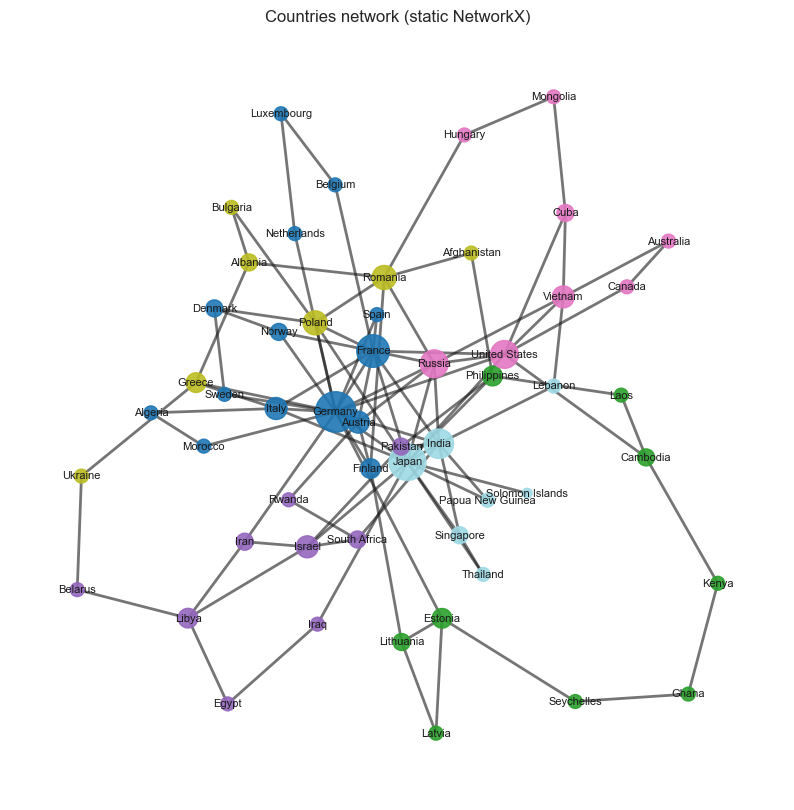

In [39]:
#Creating static network graph using NetworkX.
# Get raw weights
raw_weights = [G[u][v].get('weight', 1) for u, v in G.edges()]

# Normalize to a visible range, e.g. widths between 1 and 6
w_min, w_max = min(raw_weights), max(raw_weights)

if w_max == w_min:
    # All weights the same → just use 2 for everything
    edge_widths = [2 for _ in raw_weights]
else:
    edge_widths = [
        1 + 5 * (w - w_min) / (w_max - w_min)   # maps min→1, max→6
        for w in raw_weights
    ]
plt.figure(figsize=(10,10))
nx.draw_networkx_nodes(G, pos, node_color=colors_hex, node_size=node_sizes, alpha=0.9)
nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.6)
nx.draw_networkx_labels(G, pos, font_size=8)

plt.title("Countries network (static NetworkX)")
plt.axis('off')
plt.show()

In [27]:
#Interactive Pyvis visualization
pyvis_net = Network(height="800px", width="100%", notebook=True, bgcolor="#ffffff", font_color="black")
pyvis_net.from_nx(G)
pyvis_net.show_buttons(filter_=['physics'])

output_html1 = "countries_network_interactive.html"
pyvis_net.show(output_html1)
print(f"Saved interactive network to {output_html1}")

countries_network_interactive.html
Saved interactive network to countries_network_interactive.html


In [18]:
#Applying the Leiden algorithm to detect any communities
nodes = list(G.nodes())
node_to_idx = {n:i for i,n in enumerate(nodes)}
edges_ig = [(node_to_idx[u], node_to_idx[v]) for u,v in G.edges()]
g_ig = ig.Graph(n=len(nodes), edges=edges_ig, directed=False)

#Adding weights
weights = [G[u][v].get('weight', 1.0) for u,v in G.edges()]
g_ig.es['weight'] = weights

partition = leidenalg.find_partition(g_ig, leidenalg.RBConfigurationVertexPartition, weights=g_ig.es['weight'])
membership = partition.membership
community_map = {nodes[i]: membership[i] for i in range(len(nodes))}
num_communities = len(set(membership))
print(f"Found {num_communities} communities")

Found 6 communities


In [28]:
#Applying the Leiden algorithm to detect any communities
nodes = list(G.nodes())
node_to_idx = {n:i for i,n in enumerate(nodes)}
edges_ig = [(node_to_idx[u], node_to_idx[v]) for u,v in G.edges()]
g_ig = ig.Graph(n=len(nodes), edges=edges_ig, directed=False)

#Adding weights
weights = [G[u][v].get('weight', 1.0) for u,v in G.edges()]
g_ig.es['weight'] = weights

partition = leidenalg.find_partition(g_ig, leidenalg.RBConfigurationVertexPartition, weights=g_ig.es['weight'])
membership = partition.membership
community_map = {nodes[i]: membership[i] for i in range(len(nodes))}
num_communities = len(set(membership))
print(f"Found {num_communities} communities")

Found 7 communities


In [19]:
#importing cm
from matplotlib import cm

In [29]:
# Visualizing the communities 
palette = cm.get_cmap('tab20', num_communities)

# Computing degrees (for node sizes)
degrees = dict(G.degree())
max_degree = max(degrees.values())

/var/folders/wf/s0crnzgd66b7pdj9_7_b6mpw0000gn/T/ipykernel_48606/2284535036.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  palette = cm.get_cmap('tab20', num_communities)


In [23]:
#interactive pyvis
pyvis_comm = Network(height="900px", width="100%", notebook=True,
                     bgcolor="#ffffff", font_color="black")
for n in G.nodes():
    comm = community_map[n]
    color = '#' + ''.join(f"{int(255*c):02x}" for c in palette(comm)[:3])
    # node size scaling
    node_value = (degrees[n] / max_degree) * 20 + 5
    pyvis_comm.add_node(
        n,
        label=str(n),
        title=f"{n} (comm {comm})",
        color=color,
        value=node_value )
for u, v, data in G.edges(data=True):
    w = data.get('weight', 1)
    pyvis_comm.add_edge(u, v, value=w)  
pyvis_comm.show_buttons(filter_=['physics'])
output_html2 = "countries_network_communities.html"
pyvis_comm.show(output_html2)
print(f"Saved community network to {output_html2}")

countries_network_communities.html
Saved community network to countries_network_communities.html


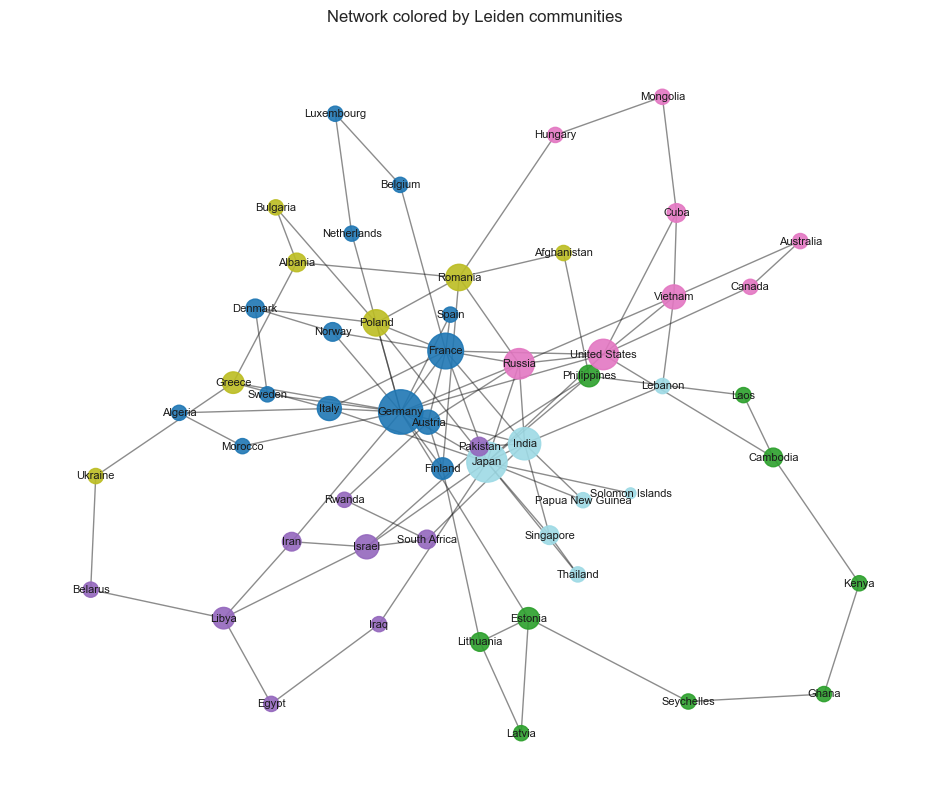

In [24]:
#Static NetworkX
pos = nx.spring_layout(G, seed=42)
# Colors per community
colors_hex = [
    '#' + ''.join(f"{int(255*c):02x}" for c in palette(community_map[n])[:3])
    for n in nodes]
# Node sizes (scaled by degree)
node_sizes = [degrees[n] * 60 for n in nodes]

# Edge widths (scaled by weight)
edge_widths = [G[u][v].get('weight', 1) for u, v in G.edges()]

plt.figure(figsize=(12, 10))
nx.draw_networkx_nodes(G, pos, node_color=colors_hex, node_size=node_sizes, alpha=0.9)
nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=8)
plt.title("Network colored by Leiden communities")
plt.axis('off')
plt.show()

In [25]:
#Calculating centrality 
deg_centrality = nx.degree_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G, normalized=True)

centrality_df = pd.DataFrame({
    'Country': list(G.nodes()),
    'Degree': [deg_centrality[n] for n in G.nodes()],
    'Closeness': [closeness_centrality[n] for n in G.nodes()],
    'Betweenness': [betweenness_centrality[n] for n in G.nodes()],
    'Community': [community_map[n] for n in G.nodes()]
})
centrality_df.sort_values('Degree', ascending=False).head(15)

,Country,Degree,Closeness,Betweenness,Community
0,Germany,0.320755,0.540816,0.418198,0
1,Japan,0.264151,0.500000,0.267458,5
8,France,0.207547,0.473214,0.097315,0
6,India,0.169811,0.430894,0.098256,5
15,United States,0.150943,0.452991,0.189516,3
4,Russia,0.150943,0.460870,0.077167,3
27,Romania,0.113208,0.370629,0.078716,4
3,Poland,0.113208,0.420635,0.073137,4
11,Israel,0.094340,0.368056,0.041719,2
2,Italy,0.094340,0.404580,0.037204,0


In [30]:
#Bar Chart
# Sort by each centrality measure
df_degree = centrality_df.sort_values('Degree', ascending=True).tail(15)
df_betw = centrality_df.sort_values('Betweenness', ascending=True).tail(15)
df_close = centrality_df.sort_values('Closeness', ascending=True).tail(15)

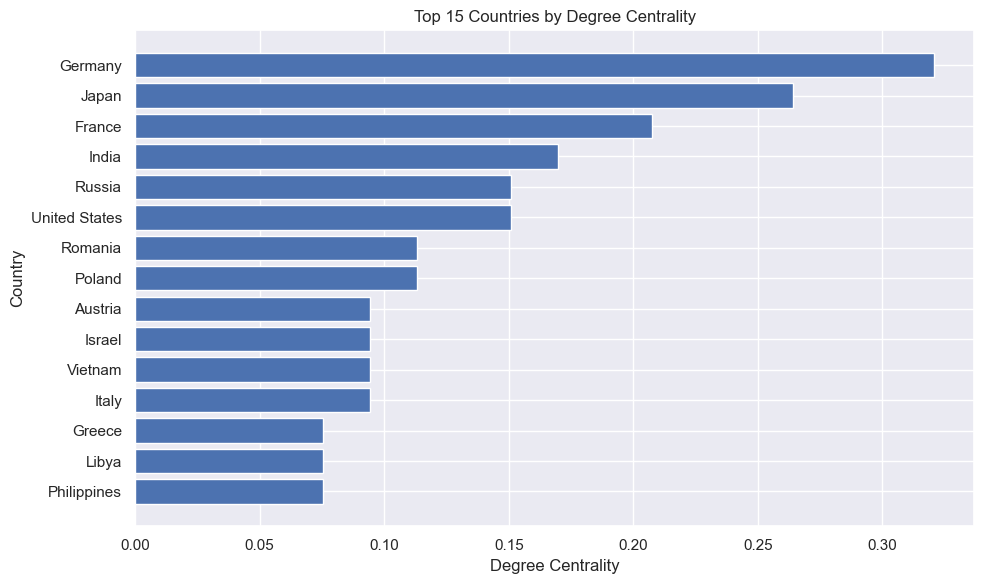

In [34]:
# DEGREE CENTRALITY (Horizontal Bar Chart)
plt.figure(figsize=(10, 6))
plt.barh(df_degree['Country'], df_degree['Degree'])
plt.title('Top 15 Countries by Degree Centrality')
plt.xlabel('Degree Centrality')
plt.ylabel('Country')
plt.tight_layout()
plt.show()

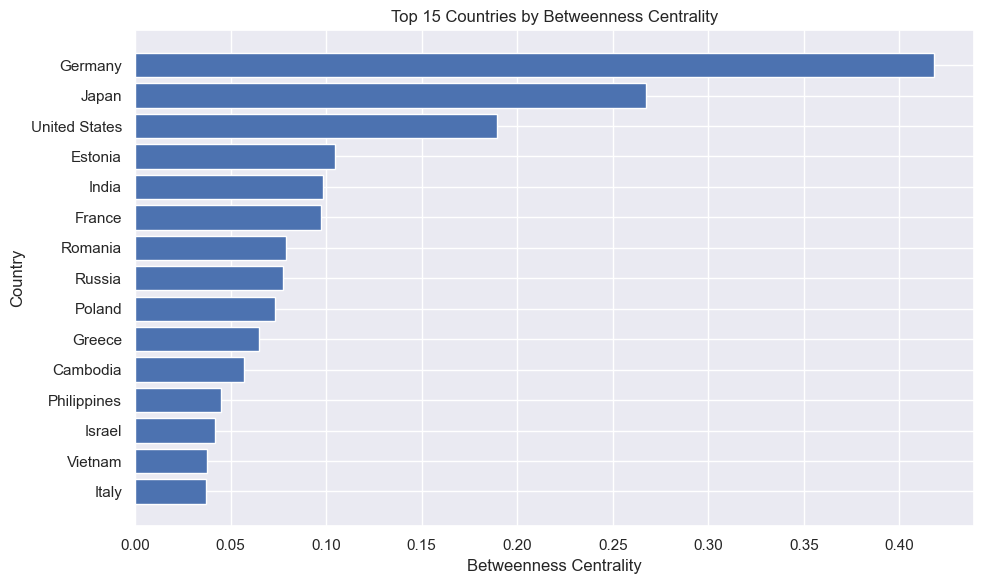

In [35]:
# BETWEENNESS CENTRALITY
plt.figure(figsize=(10, 6))
plt.barh(df_betw['Country'], df_betw['Betweenness'])
plt.title('Top 15 Countries by Betweenness Centrality')
plt.xlabel('Betweenness Centrality')
plt.ylabel('Country')
plt.tight_layout()
plt.show()

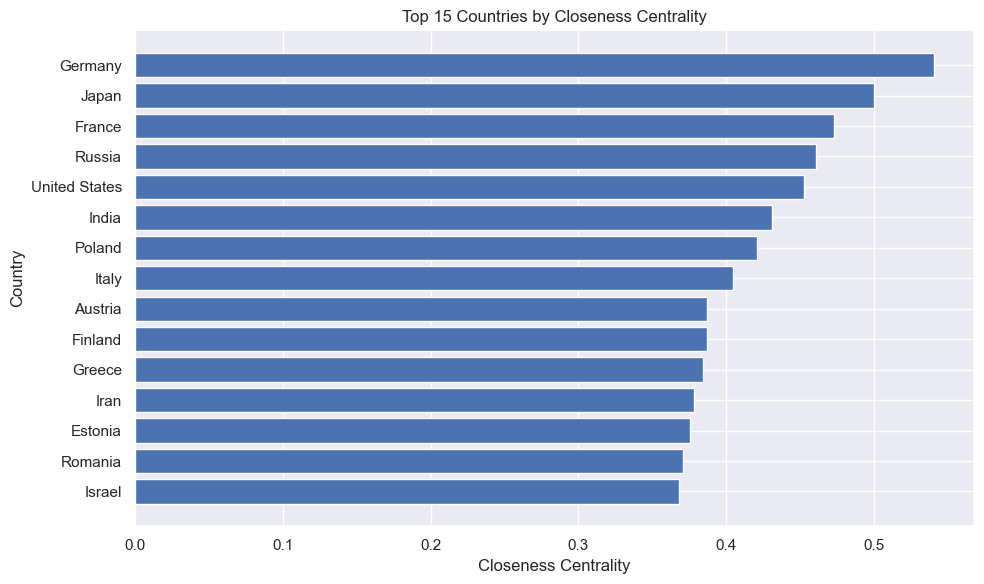

In [36]:
# CLOSENESS CENTRALITY
plt.figure(figsize=(10, 6))
plt.barh(df_close['Country'], df_close['Closeness'])
plt.title('Top 15 Countries by Closeness Centrality')
plt.xlabel('Closeness Centrality')
plt.ylabel('Country')
plt.tight_layout()
plt.show()